---



# <font color='#ECA702'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

In [1]:
#@title **Instalar paquetes necesarios**
%%capture
! pip install torchmetrics
! pip install torchinfo

In [2]:
#@title **Importar librerías**

# Manipulación de datos
import os
import cv2
import numpy as np
import pandas as pd
from zipfile import ZipFile

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader

# Pytorch metrics
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryRecall, BinaryPrecision

# Utils
import matplotlib.pyplot as plt
# import copy

# sklearn
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA

In [3]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


In [4]:
#@title **Extraer el zip**

os.mkdir('../../../../data')
os.popen('cp data.csv ../../../../data/data.csv')
target_path = os.path.join('../../../../data') # Aquí es donde van a quedar los datos
# deben quedar fuera de drive para poder acceder a ellos 'localmente'

# Unzip the downloaded files
zip_file_path = os.path.join('AudioVisualData_v7.zip')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

# # Me muevo hasta donde quedaron los datos
%cd ../../../../data
# Verifico
%ls

/content/data
AudioVisualData_v7/  data.csv


# <font color='#4C5FDA'>**1. Procesamiento del dataset**</font>

## <font color='#52F17F'>**Creación del Dataset Pandas auxiliar**</font>

In [5]:
data = pd.read_csv("data.csv", index_col='patient')

def string2array(string: str):
  """ Convierte un string con datos a numpy array """
  string = string.strip('[]')
  return np.fromstring(string, sep=',')

data['flatten_log_mel_spectogram'] = data['flatten_log_mel_spectogram'].apply(string2array)
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram
patient,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26...."


## <font color='#52F17F'>**Applying PCA**</font>

### <font color='#EB9A54'>**PCA para la disartria**</font>

In [6]:
pca = PCA(n_components=2)

In [7]:
# el vstack lo que hace es apilar arrays verticalmente
converted = pca.fit_transform(np.vstack(data['flatten_log_mel_spectogram']))
converted = [row for row in converted]
data['pca_flatten_log_mel_spectogram'] = converted
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,pca_flatten_log_mel_spectogram
patient,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[-146.87453743909924, 39.47367499338325]"
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[-214.16286829843415, 109.95630385823895]"
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[-271.45664355671505, 48.46460587132372]"
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[80.03360474596433, -30.185493254352107]"
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[-94.45165273379683, 92.81292282529023]"


### <font color='#EB9A54'>**PCA para la hipomimia**</font>

In [8]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

def preprocess_frame(frame_path: str):
  frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) # Leemos la imagen desde la ruta en escala de grises
  # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # La pasamos de BGR a RGB
  frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
  frame = frame / 255. # Normalizamos entre 0 y 1
  return frame.flatten()
  # return frame

def preprocess_video(video_path: str, n_frames = FRAMES_PROMEDIO):
  frames = []
  for frame in sorted(os.listdir(video_path))[:n_frames]:
    frames.append(preprocess_frame(f"{video_path}/{frame}"))
  return np.concatenate(frames)
  # return frames

# Preprocesar todos los audios y almacenar los espectrogramas mel
data['flatten_frame_sequence'] = data['frames_path'].apply(preprocess_video)

# Verificar los datos
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,pca_flatten_log_mel_spectogram,flatten_frame_sequence
patient,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[-146.87453743909924, 39.47367499338325]","[0.44313725490196076, 0.4470588235294118, 0.44..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[-214.16286829843415, 109.95630385823895]","[0.4627450980392157, 0.4627450980392157, 0.458..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[-271.45664355671505, 48.46460587132372]","[0.4666666666666667, 0.4666666666666667, 0.474..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[80.03360474596433, -30.185493254352107]","[0.44313725490196076, 0.44313725490196076, 0.4..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[-94.45165273379683, 92.81292282529023]","[0.4627450980392157, 0.45098039215686275, 0.45..."


In [9]:
pca = PCA(n_components=14*2)

In [10]:
converted = pca.fit_transform(np.vstack(data['flatten_frame_sequence']))
converted = [row for row in converted]
data['pca_flatten_frame_sequence'] = converted
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram,pca_flatten_log_mel_spectogram,flatten_frame_sequence,pca_flatten_frame_sequence
patient,,,,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24....","[-146.87453743909924, 39.47367499338325]","[0.44313725490196076, 0.4470588235294118, 0.44...","[-4.595280588131982, 24.68374558672306, 6.6906..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8...","[-214.16286829843415, 109.95630385823895]","[0.4627450980392157, 0.4627450980392157, 0.458...","[-3.864669403016945, 22.54283968411002, 7.2301..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28...","[-271.45664355671505, 48.46460587132372]","[0.4666666666666667, 0.4666666666666667, 0.474...","[-4.720198557821532, 23.372722364432526, 5.340..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20...","[80.03360474596433, -30.185493254352107]","[0.44313725490196076, 0.44313725490196076, 0.4...","[1.182470872241323, 26.16580498762462, 9.04978..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26....","[-94.45165273379683, 92.81292282529023]","[0.4627450980392157, 0.45098039215686275, 0.45...","[-2.679659313034641, 24.02922166354198, 6.8567..."


## <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

In [11]:
class PatientDataset(Dataset):
  def __init__(self, dataframe, n_frames = FRAMES_PROMEDIO):
    self.dataframe = dataframe
    self.n_frames = n_frames

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Leemos el audio
    audio = self.dataframe['pca_flatten_log_mel_spectogram'][index].astype(np.float32)
    # audio = audio.reshape((90, 10))
    # if self.pca:
      # audio = pca.fit_transform(audio)
    audio = torch.from_numpy(audio)
    # audio = torch.from_numpy(audio)

    """ Carga de los frames """

    # video_path = os.path.join(self.dataframe['frames_path'][index])
    frames = self.dataframe['pca_flatten_frame_sequence'][index].astype(np.float32)

    # frames_path = sorted(os.listdir(video_path))[:self.n_frames]
    # frames = []
    # for frame in frames_path:
    #   frame_path = os.path.join(self.dataframe['frames_path'][index], frame)
    #   # print(frame_path)
    #   frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    #   frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
    #   frame = frame / 255. # Normalizamos entre 0 y 1
    #   if self.pca:
    #     frame = pca.fit_transform(frame)
    #   frames.append(frame)

    # frames = np.expand_dims(np.stack(frames), axis=1).astype('float32')
    # frames = frames.transpose(1, 0, 2, 3)
    frames = torch.from_numpy(frames)

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'Parkinson' 1
    # sino 0.

    label = 1 if 'Parkinson' in self.dataframe['audio_path'][index] else 0

    return audio, frames, label


In [12]:
complete_dataset = PatientDataset(data)
print(complete_dataset.__len__())
print(complete_dataset[0][0].shape, complete_dataset[0][1].shape , complete_dataset[0][2])

1091
torch.Size([2]) torch.Size([28]) 0


## <font color='#52F17F'>**Partición de los datos**</font>

In [13]:
# Extraer los datos para GroupKFold
X = [i for i in range(len(data))]
y = data['label'].values
groups = data.index.values

groupk_folds = 7
gkf = GroupKFold(n_splits=groupk_folds)

# Realizar la validación cruzada por grupos
for i, (train_index, test_index) in enumerate(gkf.split(X, y, groups), 1):
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    print(f"División {i}:")
    print("  Pacientes en entrenamiento:", np.unique(train_groups))
    print("  Pacientes en prueba:", np.unique(test_groups))
    print("  Número de pacientes en entrenamiento:", len(np.unique(train_groups)))
    print("  Número de pacientes en prueba:", len(np.unique(test_groups)))
    print()


División 1:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C4' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P7']
  Pacientes en prueba: ['C5' 'P8']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 2:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P8']
  Pacientes en prueba: ['C4' 'P7']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 3:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P7' 'P8']
  Pacientes en prueba: ['C3' 'P6']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 4:
  Pacientes en entrenamiento: ['C0' 'C2' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P6' 'P7' 'P8']
  Pacientes en prueba: ['C1' 'P5']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 5:
  Pacientes en entrenamiento: ['C0' 'C1' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P5' 'P6' 'P7' 'P8']
  Pacientes en prueba: [

In [14]:
def make_folds(data:pd.DataFrame):
    # Extraer los datos para GroupKFold
    X = np.array([i for i in range(len(data))])
    y = data['label'].values
    groups = data.index.values

    folds_dict = {}
    groupk_folds = 7
    gkf = GroupKFold(n_splits=groupk_folds)

    # Realizar la validación cruzada por grupos
    for i, (train_index, test_index) in enumerate(gkf.split(X, y, groups), 1):
        fold_name = f"fold_{i}"
        folds_dict[fold_name] = {
            'train': train_index,
            'test': test_index
        }

    return folds_dict

def make_subdataframes(data:pd.DataFrame, folds:dict):
  # Crear subdataframes
  subdataframes = {}

  for fold_name, indices in folds.items():
      train_df = data.iloc[indices['train']]
    #   val_df = data.iloc[indices['val']]
      test_df = data.iloc[indices['test']]

      subdataframes[fold_name] = {
          'train': train_df,
        #   'val': val_df,
          'test': test_df
      }

  return subdataframes

In [15]:
def get_data(slice=1, fold:int=None):

    # Generate folds
    folds = make_folds(data)

    # Create subdataframes
    subdataframes = make_subdataframes(data, folds)

    if not fold:
      fold = np.random.choice(range(1, 8))

    fold_name = f'fold_{fold}'
    print(f"FOLD {fold}\n-------------------------------")

    train_dataset = PatientDataset(subdataframes[fold_name]['train'])
    test_dataset = PatientDataset(subdataframes[fold_name]['test'])

    # test with less data, it helped me to set up the experiments faster if slice=1
    # then it returns the complete dataset
    train_dataset = torch.utils.data.Subset(train_dataset,
                                            indices=range(0, len(train_dataset), slice))
    test_dataset = torch.utils.data.Subset(test_dataset,
                                            indices=range(0, len(test_dataset), slice))

    return train_dataset, test_dataset

def make_loader(dataset, batch_size):
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                        pin_memory=True, num_workers=2)
    return loader

# <font color='#ECA702'>**2. Deep Learning 🤖**</font>

## <font color='#EB9A54'>**Multimodal fully connected model**</font>

In [20]:
class MiddleModule(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.fc = nn.Linear(in_features, out_features)
    self.relu = nn.ReLU(inplace=True)
    self.dropout = nn.Dropout(inplace=True)

  def forward(self, x):
    x = self.fc(x)
    x = self.relu(x)
    return x

class MultimodalModel(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.fc1 = nn.Linear((14*2+2), 1024)
    self.features_module = nn.Sequential(
      MiddleModule(1024, 512),
      MiddleModule(512, 256),
      MiddleModule(256, 128),
    )
    self.fc4 = nn.Linear(128, n_classes)


  def forward(self, audio, video):
    # https://stackoverflow.com/questions/42479902/what-does-view-do-in-pytorch
    # audio = audio.view(audio.size(0), -1) # Aplane los audios conservando el batch
    # devuelve: # batch_size x (90*10)

    # video = video.view(video.size(0), -1) # Aplane los videos conservando el batch
    # devuelve: # batch_size x (14*112*112)

    combined = torch.cat((video, audio), dim=1) # https://pytorch.org/docs/stable/generated/torch.cat.html
    x = F.relu(self.fc1(combined))
    # x = self.fc1(combined)
    x = self.features_module(x)
    x = self.fc4(x)
    return x

In [21]:
# Test al modelo, para ver si nos entrega la salida esperada

input_audio = torch.rand([2, 2])
input_video = torch.rand([2, 14*2])
print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = MultimodalModel(n_classes=1)
ouput = model(input_audio, input_video)
print(f"Salida: {ouput.size()}")

Entrada audio: (torch.Size([2, 2]), torch.float32)
Entrada video: (torch.Size([2, 28]), torch.float32)
Salida: torch.Size([2, 1])


In [22]:
print(model)

MultimodalModel(
  (fc1): Linear(in_features=30, out_features=1024, bias=True)
  (features_module): Sequential(
    (0): MiddleModule(
      (fc): Linear(in_features=1024, out_features=512, bias=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=True)
    )
    (1): MiddleModule(
      (fc): Linear(in_features=512, out_features=256, bias=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=True)
    )
    (2): MiddleModule(
      (fc): Linear(in_features=256, out_features=128, bias=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.5, inplace=True)
    )
  )
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)


In [23]:
summary(model, (input_video.size(), input_audio.size()))
# summary(model, input_video.size())

Layer (type:depth-idx)                   Output Shape              Param #
MultimodalModel                          [2, 1]                    --
├─Linear: 1-1                            [2, 1024]                 31,744
├─Sequential: 1-2                        [2, 128]                  --
│    └─MiddleModule: 2-1                 [2, 512]                  --
│    │    └─Linear: 3-1                  [2, 512]                  524,800
│    │    └─ReLU: 3-2                    [2, 512]                  --
│    └─MiddleModule: 2-2                 [2, 256]                  --
│    │    └─Linear: 3-3                  [2, 256]                  131,328
│    │    └─ReLU: 3-4                    [2, 256]                  --
│    └─MiddleModule: 2-3                 [2, 128]                  --
│    │    └─Linear: 3-5                  [2, 128]                  32,896
│    │    └─ReLU: 3-6                    [2, 128]                  --
├─Linear: 1-3                            [2, 1]                    

## <font color='#EB9A54'>**Utils functions and hyperparameters**</font>

In [78]:
# Hiperparametros
LEARNING_RATE = 0.0002
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 234

In [26]:
#@title **train batch**

def train_batch(audios, videos, labels, model, optimizer, criterion, metrics_fn):
  audios, videos, labels = audios.to(DEVICE), videos.to(DEVICE), labels.to(DEVICE)

  # Forward pass ➡
  outputs = model(audios, videos)
  loss = criterion(outputs, labels.unsqueeze(1).float())
  accuracy = metrics_fn(outputs, labels.unsqueeze(1).float())

  # Backward pass ⬅
  optimizer.zero_grad()
  loss.backward()

  # Step with optimizer
  optimizer.step()

  return loss, accuracy

In [25]:
#@title **train loop**

def train(model, train_loader, criterion, optimizer, accuracy_fn, epochs, losses):
    # 4 means that I am going to make 4 logs of the metrics when training
    n_prints = int(len(train_loader)/4)

    for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")

      train_loss, train_accuracy = 0, 0
      model.train()
      for batch, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        audios, videos, labels = data
        loss, accuracy = train_batch(audios, videos, labels, model, optimizer, criterion, accuracy_fn)
        train_loss += loss.item()
        train_accuracy += accuracy

        # Report metrics every n_prints batch
        if batch % n_prints == n_prints-1:
            losses.append(train_loss/(batch+1))
            print(f"train loss: {train_loss/(batch+1):.3f} accuracy: {train_accuracy/(batch+1):.3f} [after {batch+1} batches]")

In [27]:
#@title **test loop**

def test(model, test_loader, accuracy_fn, f1_score_fn, recall_fn, precision_fn):
    model.eval()

    # Run the model on some test examples
    num_batches = len(test_loader)
    test_accuracy, test_f1, test_recall, test_precision = 0, 0, 0, 0

    # Disable gradient calculation
    with torch.no_grad():
        for audios, videos, labels in test_loader:
            audios, videos, labels = audios.to(DEVICE), videos.to(DEVICE), labels.to(DEVICE)
            outputs = model(audios, videos)
            test_accuracy += accuracy_fn(outputs, labels.unsqueeze(1).float())
            test_f1 += f1_score_fn(outputs, labels.unsqueeze(1).float())
            test_recall += recall_fn(outputs, labels.unsqueeze(1).float())
            test_precision += precision_fn(outputs, labels.unsqueeze(1).float())

        # Average the metrics over all batches
        test_accuracy /= num_batches
        test_f1 /= num_batches
        test_recall /= num_batches
        test_precision /= num_batches

        print(f"test accuracy: {test_accuracy:.3f} recall: {test_recall:.3f} precision: {test_precision:.3f} f1: {test_f1:.3f} [after {num_batches} batches]")

    return test_accuracy, test_f1, test_recall, test_precision

In [79]:
def make(fold=None):

  # Make the data
  train, test = get_data(slice=1, fold=fold)
  train_loader = make_loader(train, batch_size=BATCH_SIZE)
  test_loader = make_loader(test, batch_size=BATCH_SIZE)

  # Creacion del modelo y lo movemos a la GPU o CPU
  model = MultimodalModel(n_classes=1).to(DEVICE)

  # Funcion de perdida (loss)
  criterion = nn.BCEWithLogitsLoss() # https://shivambaldha.medium.com/binary-classification-with-pytorch-85089b284940

  # Algoritmos de optimización del gradiente
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  # Make metrics
  accuracy_fn = BinaryAccuracy().to(DEVICE)
  f1_score_fn = BinaryF1Score().to(DEVICE)
  recall_fn = BinaryRecall().to(DEVICE)
  precision_fn = BinaryPrecision().to(DEVICE)

  EPOCHS = 15

  return model, train_loader, test_loader, criterion, optimizer, accuracy_fn, f1_score_fn, recall_fn, precision_fn, EPOCHS

## <font color='#52F17F'>**Fusion of features**</font>

In [80]:
# Acá vamos a guardar las métricas del modelo
results = {
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": []
}

# Storage losses for plotting
losses_per_epoch = []

# Loop encontrado y modificado de: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
for fold in range(1, 8):
  # Storage for current fold
  losses = []

  # make the model, data, loss, metrics and optimization problem
  model, train_loader, test_loader, criterion, optimizer, accuracy_fn, f1_score_fn, recall_fn, precision_fn, epochs = make(fold=fold)

  # and use them to train the mod
  train(model, train_loader, criterion, optimizer, accuracy_fn, epochs, losses)

  # get metrics of the model
  test_accuracy, test_f1, test_recall, test_precision = test(model, test_loader, accuracy_fn, f1_score_fn, recall_fn, precision_fn)

  # Store losses for current fold
  losses_per_epoch.append(losses)

  results["accuracy"].append(test_accuracy.cpu() * 100)
  results["recall"].append(test_recall.cpu() * 100)
  results["precision"].append(test_precision.cpu() * 100)
  results["f1_score"].append(test_f1.cpu() * 100)

FOLD 1
-------------------------------
Epoch 1
-------------------------------
train loss: 0.805 accuracy: 0.521 [after 1 batches]
train loss: 0.736 accuracy: 0.611 [after 2 batches]
train loss: 0.700 accuracy: 0.671 [after 3 batches]
train loss: 0.667 accuracy: 0.694 [after 4 batches]
Epoch 2
-------------------------------
train loss: 0.538 accuracy: 0.791 [after 1 batches]
train loss: 0.509 accuracy: 0.825 [after 2 batches]
train loss: 0.489 accuracy: 0.845 [after 3 batches]
train loss: 0.468 accuracy: 0.871 [after 4 batches]
Epoch 3
-------------------------------
train loss: 0.409 accuracy: 0.927 [after 1 batches]
train loss: 0.379 accuracy: 0.940 [after 2 batches]
train loss: 0.351 accuracy: 0.947 [after 3 batches]
train loss: 0.343 accuracy: 0.945 [after 4 batches]
Epoch 4
-------------------------------
train loss: 0.291 accuracy: 0.949 [after 1 batches]
train loss: 0.261 accuracy: 0.957 [after 2 batches]
train loss: 0.252 accuracy: 0.962 [after 3 batches]
train loss: 0.253 acc

In [81]:
# Print fold results
print(f'GROUP K-FOLD CROSS VALIDATION RESULTS FOR {groupk_folds} FOLDS')
print('--------------------------------')
for metric, values in results.items():
    print(f'{metric}:')
    for fold_idx, value in enumerate(values, 1):
        print(f'  fold {fold_idx}: {value:.2f}')
    print(f'  average: {np.mean(values):.2f}% (+/- {np.std(values):.2f}%)')

GROUP K-FOLD CROSS VALIDATION RESULTS FOR 7 FOLDS
--------------------------------
accuracy:
  fold 1: 90.38
  fold 2: 89.74
  fold 3: 89.74
  fold 4: 92.95
  fold 5: 86.54
  fold 6: 50.00
  fold 7: 71.61
  average: 81.57% (+/- 14.45%)
recall:
  fold 1: 85.90
  fold 2: 93.59
  fold 3: 89.74
  fold 4: 98.72
  fold 5: 73.08
  fold 6: 1.28
  fold 7: 100.00
  average: 77.47% (+/- 32.21%)
precision:
  fold 1: 94.37
  fold 2: 86.90
  fold 3: 89.74
  fold 4: 88.51
  fold 5: 100.00
  fold 6: 50.00
  fold 7: 63.64
  average: 81.88% (+/- 16.75%)
f1_score:
  fold 1: 89.93
  fold 2: 90.12
  fold 3: 89.74
  fold 4: 93.33
  fold 5: 84.44
  fold 6: 2.50
  fold 7: 77.78
  average: 75.41% (+/- 30.14%)


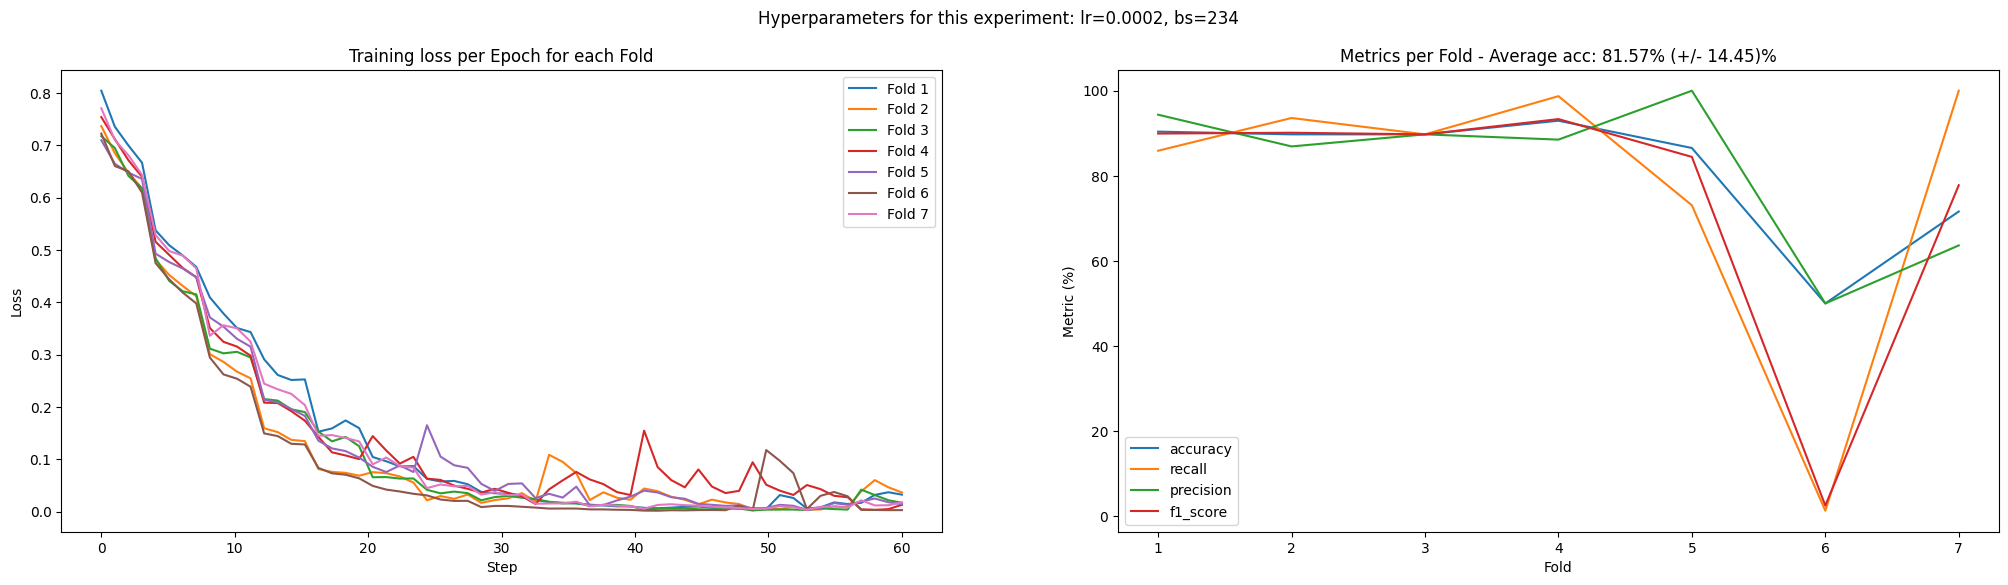

In [82]:
# Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

# Plot 1: Loss per epoch
n_epochs = [len(losses) for losses in losses_per_epoch] # Lista que tiene las épocas a las que llego cada fold * 3 prints para cada epoch
for n_epochs, fold_losses in zip(n_epochs, losses_per_epoch):
    ax1.plot(np.linspace(0, n_epochs, n_epochs), fold_losses, label=f'Fold {losses_per_epoch.index(fold_losses) + 1}')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training loss per Epoch for each Fold')
ax1.legend()

# Plot 2: Metrics per fold
for metric, values in results.items():
    if metric == 'accuracy':
        mean, std = np.mean(values), np.std(values)
    ax2.plot(range(1, groupk_folds + 1), values, label=f'{metric}')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Metric (%)')
ax2.set_title(f'Metrics per Fold - Average acc: {mean:.2f}% (+/- {std:.2f})%')
ax2.legend()

# Título principal
fig.suptitle(f'Hyperparameters for this experiment: lr={LEARNING_RATE}, bs={BATCH_SIZE}')
plt.show()